## Is it a Chihuahua or a Blueberry Muffin?

-forked from is it a bird fastai notebook

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.9 MB/s eta 0:00:00a 0:00:01


The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "blueberry muffin photos"
1. Use DuckDuckGo to search for images of "chihuahua photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a chihuahua and see if it works.

## Step 1: Download images of muffins and non-muffins

In [2]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for a blueberry muffin photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('blueberry muffin', max_images=3)
urls[0:4]

(#3) ['https://cdn3.tmbi.com/secure/RMS/attachments/37/1200x1200/Blueberry-Muffins_exps2251_W101973175A05_18_1bC_RMS.jpg','https://bunnyswarmoven.net/wp-content/uploads/2017/08/2017-08-19_7419-1.jpg','https://bakerbynature.com/wp-content/uploads/2011/05/Blueberry-Muffins-1-of-1.jpg']

...and then download a URL and take a look at it:

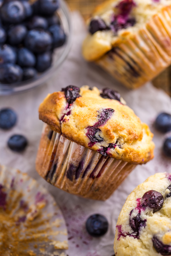

In [4]:
from fastdownload import download_url
dest = 'muffin.jpg'
download_url(urls[2], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "chihuahua photos":

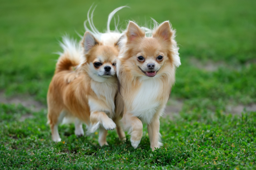

In [5]:
download_url(search_images('chihuahua photos', max_images=1)[0], 'chihuahua.jpg', show_progress=False)
Image.open('chihuahua.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "chihuahua" and "muffin" photos, and save each group of photos to a different folder:

In [6]:
searches = 'blueberry_muffin','chihuahua'
path = Path('dog_or_muffin')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

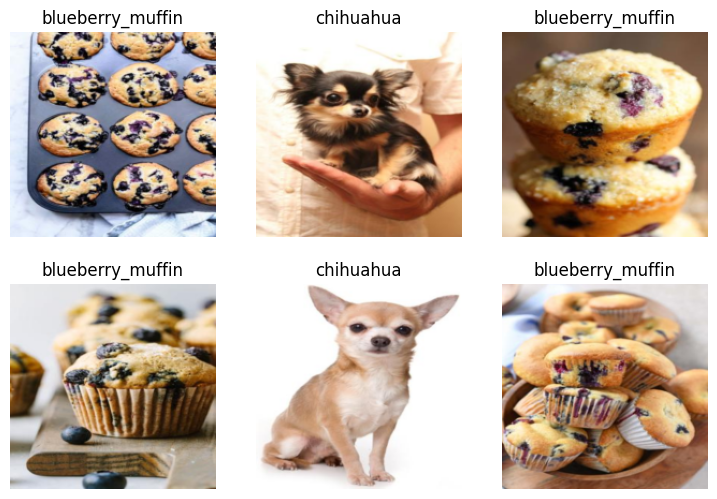

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "blueberry muffin" or "chihuahua").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *blueberry_muffin* or *chihuahua*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.0MB/s]


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that blueberry muffin we downloaded at the start:

<Axes: title={'center': "Probability it's a muffin: 1.000"}>

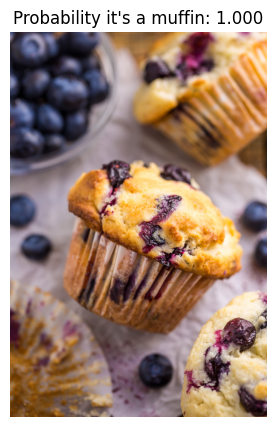

In [10]:
is_muffin,_,probs = learn.predict(PILImage.create('muffin.jpg'))
# print(f"This is a: {is_muffin}.")
# titled = f"Probability it's a muffin: {probs[0]:.3f}"
PILImage.create('muffin.jpg').show(title=f"Probability it's a muffin: {probs[0]:.3f}")

<Axes: title={'center': "Probability it's a muffin: 0.000"}>

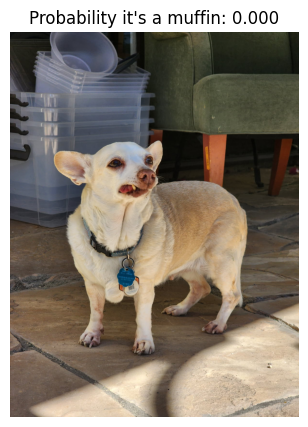

In [11]:
image_path = '/kaggle/input/trevorstoof/image000001.jpg'
is_muffin,_,probs = learn.predict(PILImage.create(image_path))
# print(f"This is a: {is_muffin}.")
# titled = f"Probability it's a muffin: {probs[0]:.3f}"
PILImage.create(image_path).show(title=f"Probability it's a muffin: {probs[0]:.3f}")

This is a: blueberry_muffin.


<Axes: title={'center': "Probability it's a muffin: 0.834"}>

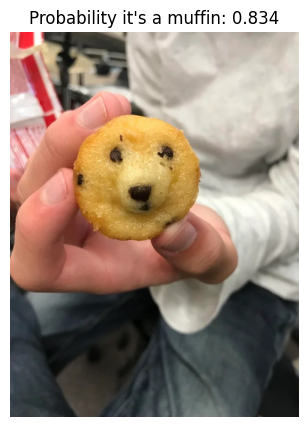

In [29]:

image_path = '/kaggle/input/definitely-dog/IMG_9927.jpg'
is_muffin,_,probs = learn.predict(PILImage.create(image_path))
print(f"This is a: {is_muffin}.")
# titled = f"Probability it's a muffin: {probs[0]:.3f}"
PILImage.create(image_path).show(title=f"Probability it's a muffin: {probs[0]:.3f}")

This is a: blueberry_muffin.


<Axes: title={'center': "Probability it's a muffin: 0.796"}>

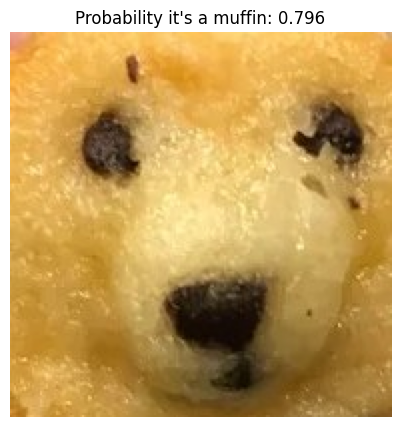

In [30]:

image_path = '/kaggle/input/definitely-dog/IMG_9927_zoom.jpg'
is_muffin,_,probs = learn.predict(PILImage.create(image_path))
print(f"This is a: {is_muffin}.")
# titled = f"Probability it's a muffin: {probs[0]:.3f}"
PILImage.create(image_path).show(title=f"Probability it's a muffin: {probs[0]:.3f}")

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

# Testing on additional images and viewing error rates

Ok, so one image is no problem, now I really want to know where it gets it right, where it is a little confused, and where it gets it wrong all the time. There was an error rate on the validation set of 0.01 or 1% - and out of hundreds of images that means a few are going to be interesting - and probably funny.

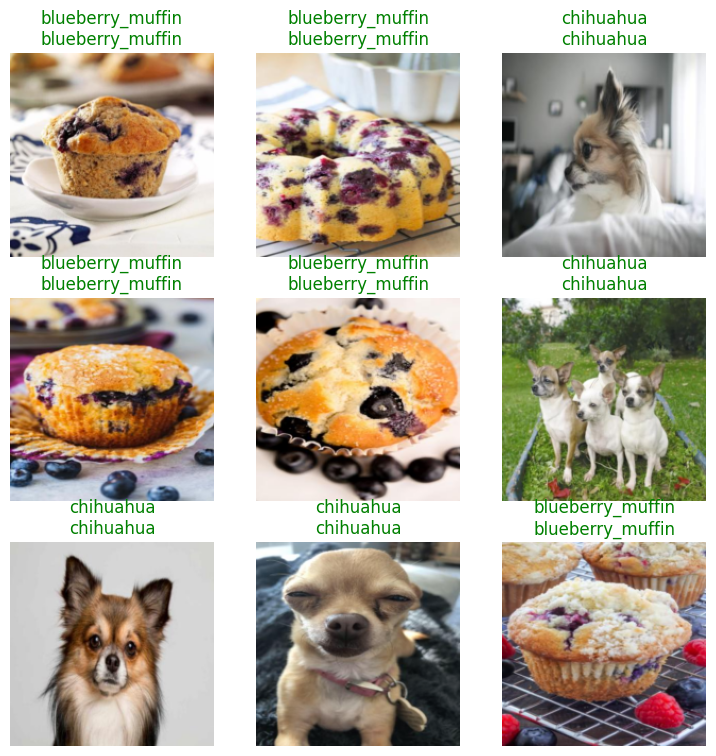

In [14]:
# First let's just play with show results
# It seems that a random set of 9 images is used for this
learn.show_results()

In [34]:
# Let's see what tools fast.ai has to explore model results even better.

# First, can we interact with the files saved blind to which dataset they're in,
# and then understand what prediction values are returned.

# Path was defined initially when we got the files with the same get_image_files function
# Assuming it was imported with:     from fastcore.all import *
files = get_image_files(path/"blueberry_muffin")
print(len(files))

# files looks like a list that can be indexed into - 
# because we pointed to blueberry muffins I'll only have muffin files
files[0]

# it's interesting that the notebook prints the files [0] command without calling print

188


Path('dog_or_muffin/blueberry_muffin/31cd3d0c-8dc1-4f76-8130-747d60ac13ea.jpg')

In [16]:
# Now let's interact with a files object
learn.predict(files[0])

('blueberry_muffin', tensor(0), tensor([1.0000e+00, 7.9341e-09]))

That third item is the probability of **muffin** (0.999999) or **chihuahua** (0.000008)
Clearly it decided that the muffin was more likely here.

In [17]:
# I want to see if I can iterate for each file and return the lowest predicted value
# Even if many of these are going to be part of the training set and high probability
# Let's first make sure we can interact with the probability item
_,_,probability = learn.predict(files[0])
probability

tensor([1.0000e+00, 7.9341e-09])

In [18]:
# confirming that even the tensor item? array?
probability.type

<function Tensor.type>

In [19]:
# aha - it's an object - oh python, you never stop do you?
# the first index of the type is the probability of muffin
probability[0]

tensor(1.)

In [20]:
# online instructions are to use the item() method to interact with the value itself
probability[0].item()

1.0

In [35]:
# ok now that we have a float we know how to get that float for all predictions
muffin_preds = []

# make sure to save the index of the file when 
for index, file in files.enumerate():
    _,_,probability = learn.predict(file)
    value = probability[0].item()
    muffin_preds.append({"index":index, "pred": value})

# let's print how many we have because I'm paranoid about this sort of error
len(muffin_preds)

188

In [42]:
muffin_preds[0:5]

[{'index': 0, 'pred': 1.0},
 {'index': 1, 'pred': 1.0},
 {'index': 2, 'pred': 0.9999995231628418},
 {'index': 3, 'pred': 1.0},
 {'index': 4, 'pred': 1.0}]

In [32]:
# success - it did take a few seconds to create predictions for all of the images
# think I can now sort the array and print the first few values when sorted.
sorted_preds = sorted(muffin_preds, key=itemgetter('pred'))

# Let's see the indexes of the lowest predictions (they're still going to be muffins)
sorted_preds[0:5]



[{'index': 186, 'pred': 0.9088557958602905},
 {'index': 34, 'pred': 0.9944221377372742},
 {'index': 30, 'pred': 0.9962357878684998},
 {'index': 85, 'pred': 0.9979561567306519},
 {'index': 128, 'pred': 0.9983080625534058}]

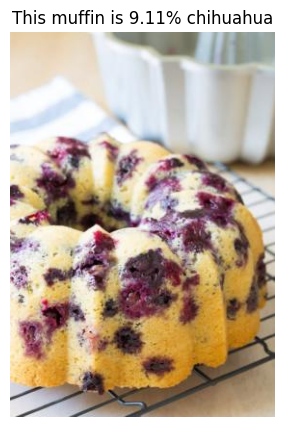

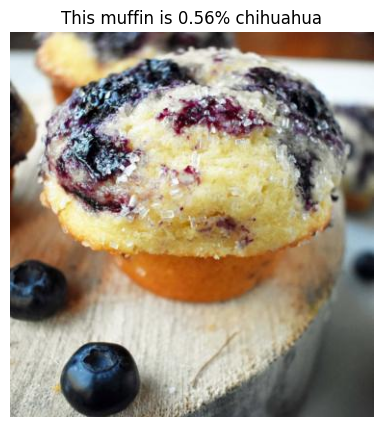

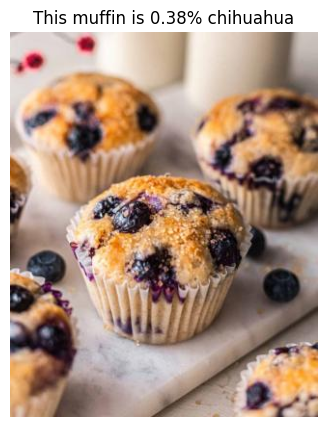

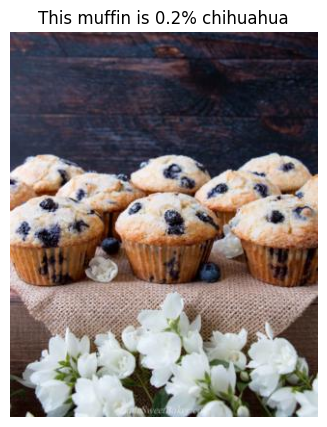

In [45]:
for muffin in sorted_preds[0:4]:
    index = muffin['index']
    pct = round(100- muffin['pred']*100,2)
    titled = f'This muffin is {pct:2g}% chihuahua'
    PILImage.create(files[index]).show(title=titled)

# THERE'S A 0.01% PROBABILITY THAT THIS IS ACTUALLY A CHIHUAHUA

In [25]:
#Let's go ahead and see the other side as well - chihuahuas that might be muffins
files = get_image_files(path/"chihuahua")

chi_preds = []

for index, file in files.enumerate():
    _,_,probability = learn.predict(file)
    value = probability[0].item()
    chi_preds.append({"index":index, "pred": value})



In [26]:

sorted_chi = sorted(chi_preds, key=itemgetter('pred'), reverse=True)


sorted_chi[0:5]

[{'index': 0, 'pred': 0.0021914574317634106},
 {'index': 186, 'pred': 0.0017137920949608088},
 {'index': 180, 'pred': 0.0008702368359081447},
 {'index': 146, 'pred': 0.0006664431421086192},
 {'index': 40, 'pred': 0.0005934247164987028}]

This dude is 0.17% muffin


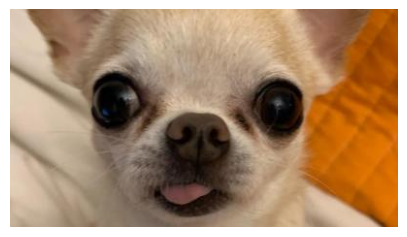

In [27]:
# This dude is a little bit muffin
index = sorted_chi[1]['index']
pct = sorted_chi[1]['pred']*100
PILImage.create(files[index]).show()

print(f'This dude is {pct:.2f}% muffin')

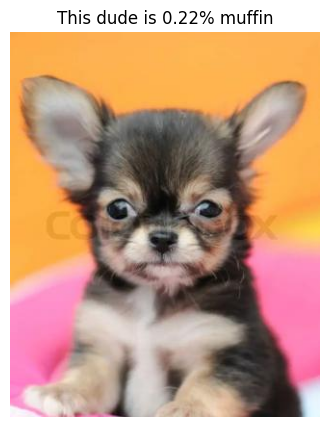

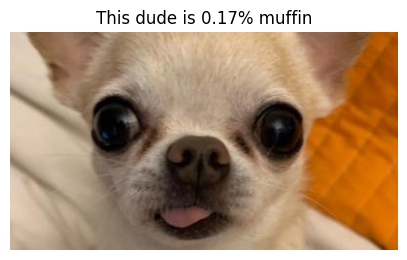

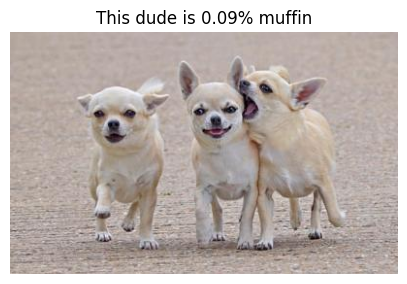

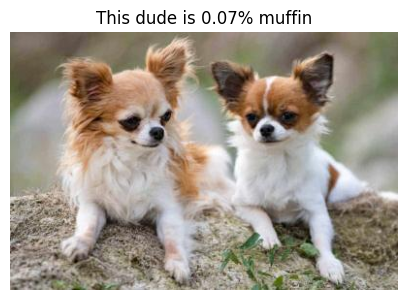

In [28]:
for dude in sorted_chi[0:4]:
    index = dude['index']
    pct = round(dude['pred']*100,2)
    titled = f'This dude is {pct:2g}% muffin'
    PILImage.create(files[index]).show(title=titled)